In [1]:
import soundfile
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import functional as F

from hybra.utils import calculate_condition_number, fir_tightener3000, fir_tightener4000, random_filterbank

In [2]:
# test signal

x, fs = soundfile.read("audio/signal.wav")
N = 5*fs
x = torch.tensor(x[:N,0], dtype=torch.float32)[None,...]
x.shape

torch.Size([1, 80000])

In [3]:
# tight auditory filterbank (no decimation)

aud_real = torch.load("filters/auditory_filters_speech.pth", map_location="cpu")['auditory_filters_real']
aud_imag = torch.load("filters/auditory_filters_speech.pth", map_location="cpu")['auditory_filters_imag']
aud = torch.tensor(aud_real + 1j * aud_imag, dtype=torch.complex64)
aud = aud.squeeze()

J = aud.shape[0]
T = aud.shape[-1]

aud_pad = torch.cat([aud, torch.zeros(J,N-T)], dim=1)
aud_tight = fir_tightener3000(aud_pad.squeeze(), 512, eps=1.01)
aud_tight_fir = aud_tight[:, :T]

print(calculate_condition_number(aud_tight), calculate_condition_number(aud_tight_fir))

/var/folders/f9/fgx5z1rj40bgh9rvgzrnnz4w0000gn/T/ipykernel_27654/771381218.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aud_real = torch.load("filters/auditory_filter

tensor(1.0097) tensor(1.0093)


In [4]:
# tight random filterbank (no decimation)
T_random = 23

random_real = random_filterbank(N, J, T_random, norm=True, support_only=False)
random_imag = random_filterbank(N, J, T_random, norm=True, support_only=False)
random = torch.tensor(random_real + 1j * random_imag, dtype=torch.complex64)
random_tight = fir_tightener4000(random, T_random, eps=1.1) # dauert ein bissi
random_tight_fir = random_tight[:, :T_random]

print(calculate_condition_number(torch.cat([random_tight, torch.zeros(J,N-T)], dim=1)))

/var/folders/f9/fgx5z1rj40bgh9rvgzrnnz4w0000gn/T/ipykernel_27654/3576893270.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random = torch.tensor(random_real + 1j * random_imag, dtype=torch.complex64)


tensor(1.0042)


In [5]:
# hybra filterbank

# komisch:
hybra_real = F.conv1d(F.pad(torch.real(aud_tight_fir), (T_random-1, 0), mode='circular').unsqueeze(0), random_tight[:,:T].unsqueeze(1).real, stride=1, groups=J).squeeze(0)
hybra_imag = F.conv1d(F.pad(torch.imag(aud_tight_fir), (T_random-1, 0), mode='circular').unsqueeze(0), random_tight[:,:T].unsqueeze(1).imag, stride=1, groups=J).squeeze(0)
hybra = hybra_real + 1j * hybra_imag

# besser:
hybra_fft = torch.fft.ifft(torch.fft.fft(aud_tight_fir, dim=1) * torch.fft.fft(random_tight[:,:T], dim=1), dim=1)

print(calculate_condition_number(hybra))
print(calculate_condition_number(hybra_fft))

tensor(1.4728)
tensor(1.0680)


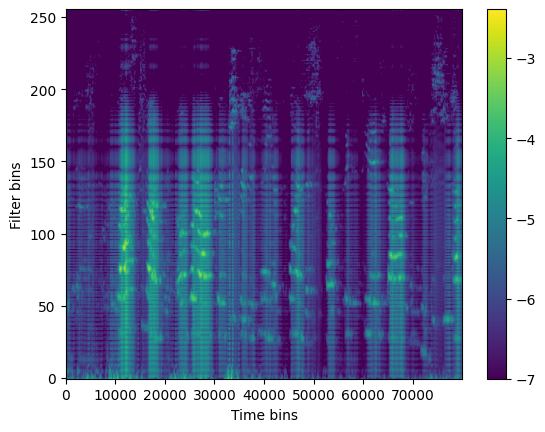

In [8]:
x_pad = F.pad(x, (T-1, 0), mode='circular')
x_fir = x_pad.unsqueeze(1)

filterbank = hybra_fft.unsqueeze(1)

x_real = F.conv1d(x_fir, torch.real(filterbank), stride=1, padding=0)
x_imag = F.conv1d(x_fir, torch.imag(filterbank), stride=1, padding=0)
x_mag = x_real**2 + x_imag**2

plt.imshow(np.log10(x_mag.numpy()[0,:,:]), vmin=-7, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde_real = F.conv_transpose1d(F.pad(x_real, (0, T-1), mode='circular'), torch.real(filterbank), stride=1, padding=T-1).squeeze(0)
x_tilde_imag = F.conv_transpose1d(F.pad(x_imag, (0, T-1), mode='circular'), torch.imag(filterbank), stride=1, padding=T-1).squeeze(0)

x_tilde = x_tilde_real + x_tilde_imag

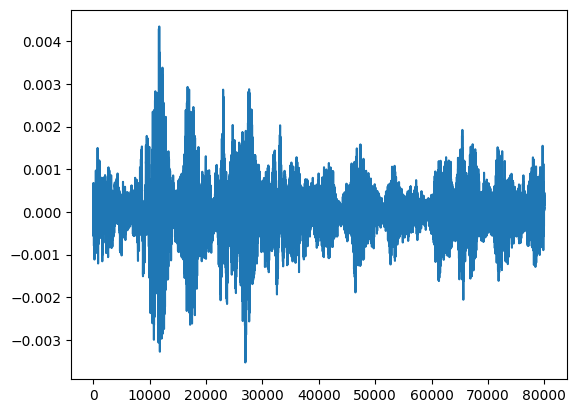

In [9]:
# reconstruction error
plt.plot(x.T.numpy() - x_tilde.T.numpy(), label='difference')

In [14]:
# play back the signal
soundfile.write("audio/reconst_audio.wav", x.T.numpy(), fs)